In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import scipy
from scipy.integrate import solve_ivp
from sklearn.linear_model import Lasso
import seaborn as sns

from utils import double_osc, lift_double_osc, lift_double_osc_dot
from tools import get_positive_contributions, compute_entropy, print_equations
import pysindy as ps

# bad code but allows us to ignore warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


In [2]:
# Initialize integrator keywords for solve_ivp to replicate the odeint defaults
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

We will fit a SINDy model to a nonlinear oscillator system:
$$ \dot{x_1} = - \omega_1 x_2, $$
$$ \dot{x_2} = \omega_1 x_1, $$
$$ \dot{x_3} = - \omega_2 x_4 + x_1^2, $$
$$ \dot{x_4} = \omega_2 x_3 $$


let

$$ y_1 = x_1, y_2=x_2, y_3=x_3, y_4=x_4, y_5=x_1^2, y_6=x_1x_2, y_7=x_2^2 $$

Whose equivlant lifted model is:
$$ \dot{y_1} = -\omega_1 x_2 = -\omega_1 y_2, $$
$$ \dot{y_2} = \omega_1 x_1 = \omega_1 y_1, $$
$$ \dot{y_3} = -\omega_2 x_4 + x_1^2 = -\omega_2 y_4 + y_5, $$
$$ \dot{y_4} = \omega_2 x_3 = \omega_2 y_3, $$
$$ \dot{y_5} = -2\omega_1 x_1 x_2 = -2\omega_1 y_6, $$
$$ \dot{y_6} = \omega_1(x_1^2 - x_2^2) = \omega_1 (y_5 - y_7), $$
$$ \dot{y_7} = 2\omega_1x_1x_2 = 2\omega_1 y_6$$

In sparse matrix:
$$\frac{d}{dt} \begin{bmatrix} y_1 \\ y_2 \\ y_3 \\ y_4 \\ y_5 \\ y_6 \\ y_7 \end{bmatrix} = \left[ \begin{array}{cc|cc|ccc} 0 & -\omega_1 & 0 & 0 & 0 & 0 & 0 \\ \omega_1 & 0 & 0 & 0 & 0 & 0 & 0 \\ \hline 0 & 0 & 0 & -\omega_2 & 1 & 0 & 0 \\ 0 & 0 & \omega_2 & 0 & 0 & 0 & 0 \\ \hline 0 & 0 & 0 & 0 & 0 & -2\omega_1 & 0 \\ 0 & 0 & 0 & 0 & \omega_1 & 0 & -\omega_1 \\ 0 & 0 & 0 & 0 & 0 & 2\omega_1 & 0 \end{array} \right] \begin{bmatrix} y_1 \\ y_2 \\ y_3 \\ y_4 \\ y_5 \\ y_6 \\ y_7 \end{bmatrix}, ~ \text{where} ~ \omega_1=1, \omega_2=1.618$$

In program, w1 = 1, and w2=1.618


### Train the model

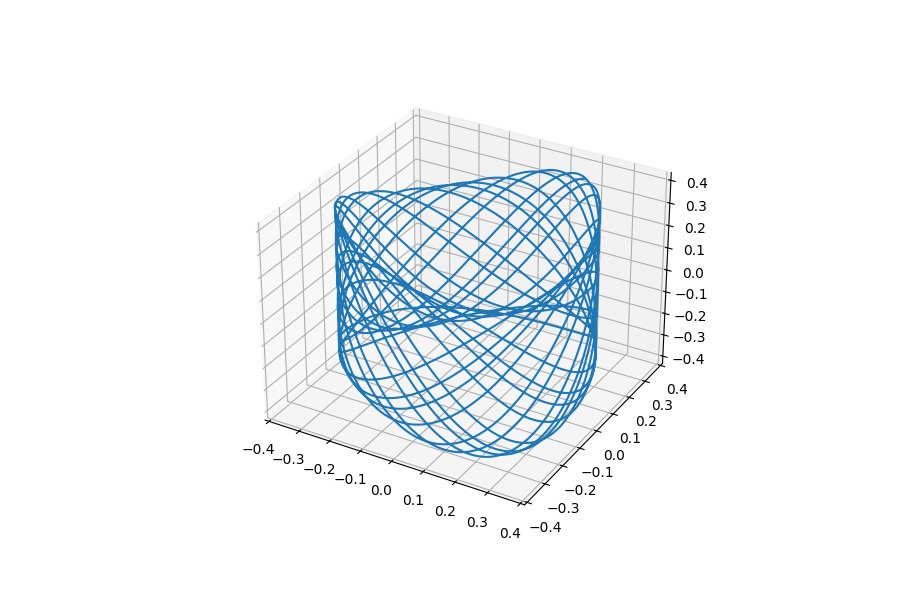

In [17]:
# Generate measurement data
dt = .01
t_train = np.arange(0, 100, dt)
ax = plt.figure(figsize=(9, 6)).add_subplot(111, projection='3d')
for y0 in np.arange(0.15, 0.16, 0.05):
    x0_train = [0.2, 0.3, 0.4, y0] # x, y, z
    t_train_span = (t_train[0], t_train[-1])
    x_train = solve_ivp(double_osc, t_train_span, x0_train, 
                        t_eval=t_train, **integrator_keywords).y.T
    ax.plot(x_train[:, 0], x_train[:, 1], x_train[:, 2])
plt.show()
# plt.plot(x_train)

In [18]:
import numpy as np
import pysindy as ps

# ====== 你已有的数据：x_train shape (N, 4) ======
# x_train
# dt = 0.01

def fit_sindy_sr3(Z, Zdot, feature_names, scheme_name,
                  nu=1.0,
                  thresholds=None,
                  max_iter=2000,
                  tol=1e-10):
    """
    用 SR3(L0) 扫 threshold（通过 calculate_l0_weight 换算 reg_weight_lam）
    并返回最稀疏且结构误差最小的模型。
    """
    if thresholds is None:
        # 对你这种 solve_ivp 无噪声数据：这个范围通常足够
        thresholds = np.logspace(-8, -3, 20)

    lib = ps.PolynomialLibrary(degree=1, include_interaction=True, include_bias=False)

    best = None
    results = []

    for thr in thresholds:
        lam = ps.SR3.calculate_l0_weight(thr, nu)  # 文档推荐的换算方式 :contentReference[oaicite:2]{index=2}

        opt = ps.SR3(
            reg_weight_lam=lam,
            regularizer="l0",
            relax_coeff_nu=nu,
            normalize_columns=True,
            unbias=True,
            max_iter=max_iter,
            tol=tol,
        )

        model = ps.SINDy(feature_library=lib, optimizer=opt, discrete_time=False)
        model.fit(Z, t=dt, x_dot=Zdot, feature_names=feature_names)

        # 评价：1) 稀疏度（非零项数） 2) 对解析 Zdot 的拟合误差
        # 注意：model.predict(Z) 在连续时间下给的是 Zdot 预测
        Zdot_pred = model.predict(Z)
        mse = np.mean((Zdot_pred - Zdot) ** 2)

        # 统计非零项数
        coef = model.coefficients()  # shape (n_targets, n_features_in_library)
        nnz = np.sum(np.abs(coef) > 1e-12)
        results.append((thr, lam, mse, nnz, model))

    # 选择规则（非常实用）：
    # 先按 mse 由小到大排序，在 mse 很小的候选里选 nnz 最小的（最稀疏）
    results.sort(key=lambda x: (x[2], x[3]))  # (mse, nnz)
    best_thr, best_lam, best_mse, best_nnz, best_model = results[0]

    print(f"\n===== Best for {scheme_name} =====")
    print(f"threshold = {best_thr:.3e}, reg_weight_lam = {best_lam:.3e}, mse = {best_mse:.3e}, nnz = {best_nnz}")
    best_model.print()

    print(f"\n\nmodel score: {best_model.score(Z, t=dt)}")

    return best_model, results


def build_Z(x_train):

    Z = np.array(lift_double_osc(x_train.T))
    Zdot = np.array(lift_double_osc_dot(Z))

    names = ["x1", "x2", "x3", "x4", "x1^2", "x1x2", "x2^2"]
    Z = Z.T
    Zdot = Zdot.T
    return Z, Zdot, names


# ====== 运行 ======
Z, Zdot, names = build_Z(x_train)
best_model, res = fit_sindy_sr3(Z, Zdot, names, 'Scheme ("x1", "x2", "x3", "x4", "x1^2", "x1x2", "x2^2")',
                              nu=1.0,
                              thresholds=np.logspace(-8, -3, 20),
                              max_iter=2000,
                              tol=1e-10)




===== Best for Scheme ("x1", "x2", "x3", "x4", "x1^2", "x1x2", "x2^2") =====
threshold = 1.000e-08, reg_weight_lam = 5.000e-17, mse = 3.281e-32, nnz = 9
(x1)' = -1.000 x2
(x2)' = 1.000 x1
(x3)' = -1.618 x4 + 1.000 x1^2
(x4)' = 1.618 x3
(x1^2)' = -2.000 x1x2
(x1x2)' = 1.000 x1^2 + -1.000 x2^2
(x2^2)' = 2.000 x1x2


model score: 0.9999999973982346


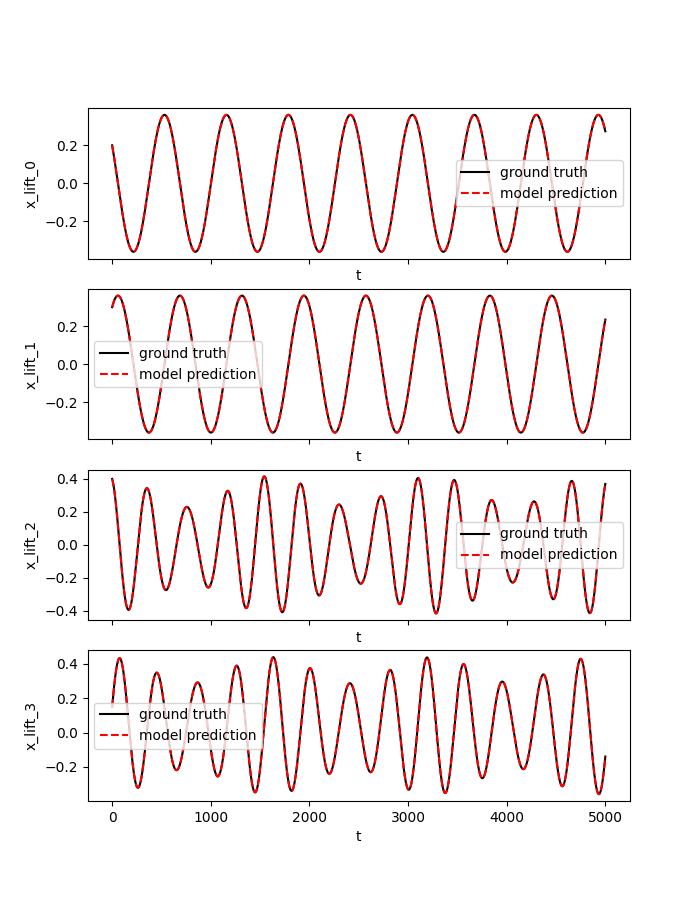

In [34]:
# 单时间序列
x_data_lift = Z
model = best_model

init_data = x_data_lift[0,:]
steps = 5000
# 多时间序列
#init_data = x_data_lift[0][0,:]

X_data_predicted = model.simulate(init_data,t_train) 

# 只看部分维度的多步预测
fig, axs = plt.subplots(4, 1, sharex=True, figsize=(7, 9))
for i in range(4):
    axs[i].plot(x_data_lift[:steps, i], "k", label="ground truth")
    axs[i].plot(X_data_predicted[:steps, i], "r--", label="model prediction")
    axs[i].legend()
    axs[i].set(xlabel="t", ylabel=r"x_lift_{}".format(i))


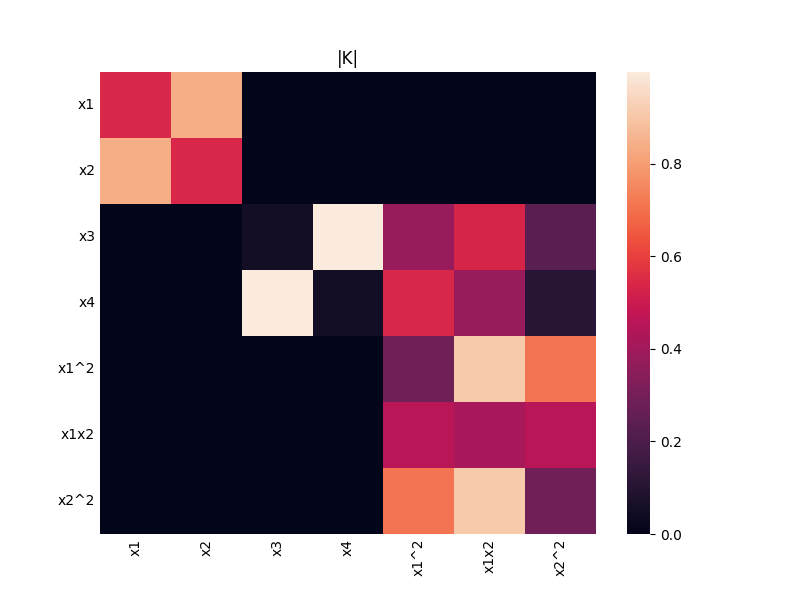

In [36]:
# 提取和处理系数矩阵
K = model.coefficients()
K = scipy.linalg.expm(K)

# 只设置参数，不自动显示全部
plt.figure(figsize=(8, 6)) # 把画布搞大一点
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(np.abs(K), xticklabels=names, yticklabels=names)
# 旋转横轴标签，避免重叠
plt.xticks(rotation=90)  # 旋转90度
plt.yticks(rotation=0)   # 纵轴保持水平
plt.title("|K|")
plt.show()

# 奇异谱分析

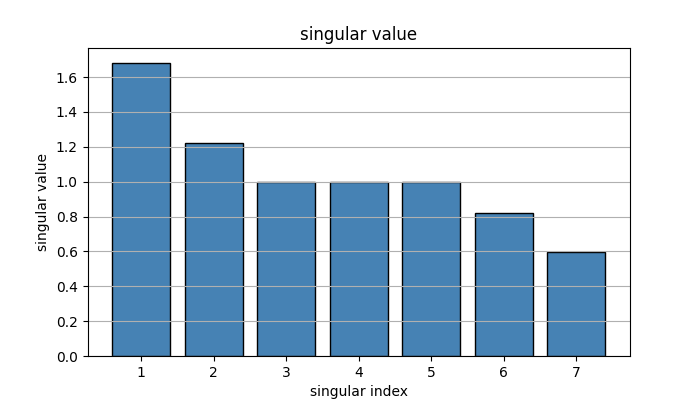

In [87]:
U,S,V = np.linalg.svd(K)
plt.figure(figsize=(7, 4))
plt.bar(np.arange(1, len(S)+1), (S), color='steelblue', edgecolor='k')
plt.grid(True, axis='y')         
plt.xlabel('singular index')
plt.ylabel('singular value')
plt.title('singular value')
plt.show()

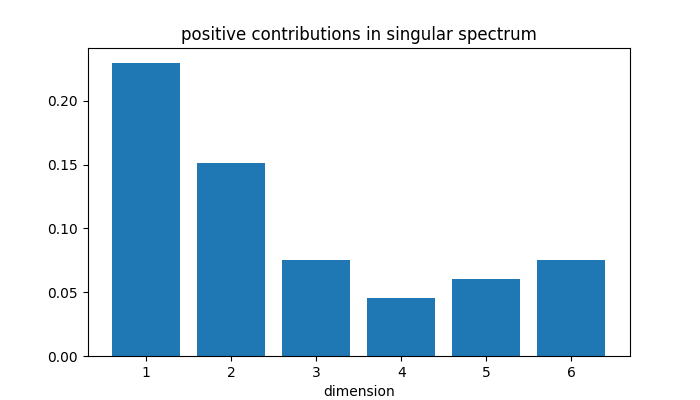

In [88]:
# 多尺度因果力分布
diff = get_positive_contributions(S)
plt.figure(figsize=(7, 4))
plt.bar(range(1,len(diff)+1), diff) 
plt.xlabel('dimension')
plt.title('positive contributions in singular spectrum')
plt.show()

In [25]:
print(compute_entropy(diff))

2.34475750305095


# 输出粗粒化表达式

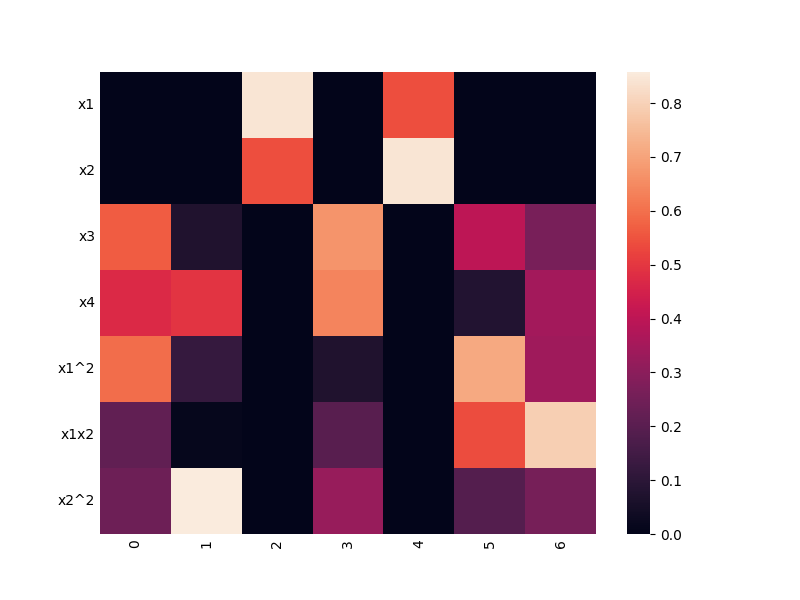

In [30]:
# 绘制奇异向量
U_abs = np.abs(U)

plt.figure(figsize=(8, 6)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(U_abs, yticklabels=names)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)   
plt.show()


# 特征谱分析

In [68]:
np.arange(1, len(evalues)+1)

array([1, 2, 3, 4, 5, 6, 7])

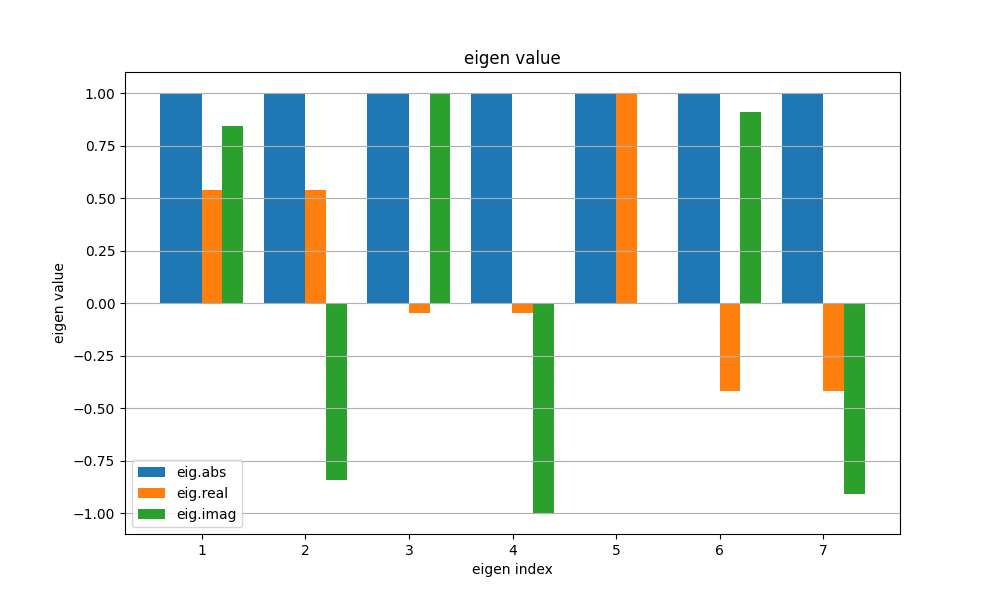

In [94]:
evalues, evectors = np.linalg.eig(K)
plt.figure(figsize=(10,6))
width = 0.2
plt.bar(np.arange(1, len(evalues)+1)-width, np.abs(evalues), 2*width)
plt.bar(np.arange(1, len(evalues)+1)+0.5*width, np.real(evalues), width)#, color='steelblue', edgecolor='k')
plt.bar(np.arange(1, len(evalues)+1)+1.5*width, np.imag(evalues), width)#, color='steelblue', edgecolor='k')
plt.grid(True, axis='y')         
plt.xlabel('eigen index')
plt.ylabel('eigen value')
plt.title('eigen value')
plt.legend(['eig.abs', 'eig.real', 'eig.imag'])
plt.show()

In [51]:
eigenvalues.shape

(7,)